In [9]:
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

model_type="encoder"
model="bert"
dataset = "civil"
bias_type="gender"
# reliance_method = "raw"
seeds = {20: list(range(1, 20))+[42], 50: list(range(1, 10))+[42], 100: [1,2,3,4,5,42], 200: [1,2,3,4,5,42], 500: [1,2,3,4,5,42]}
if dataset == "civil":
    val_nums = {"race": [20, 50, 100, 200, 500], "gender": [20, 50, 100, 200, 500], "religion": [20, 50, 100, 200]}
elif dataset == "jigsaw":
    val_nums = {"race": [20, 50, 100, 200], "gender": [20, 50, 100, 200], "religion": [20, 50, 100, 200]}
if dataset == "civil":
    test_num = {"race": 2000, "gender": 2000, "religion": 1000}
elif dataset == "jigsaw":
    test_num = {"race": 400, "gender": 800, "religion": 200}

train_type = "all"
explanation_methods = ["Attention", "Saliency", "DeepLift", "InputXGradient", "KernelShap", "Occlusion", "IntegratedGradients"]
data_dir = f"/scratch/yifwang/fairness_x_explainability/{model_type}_results_{dataset}/model_selection_correlation"



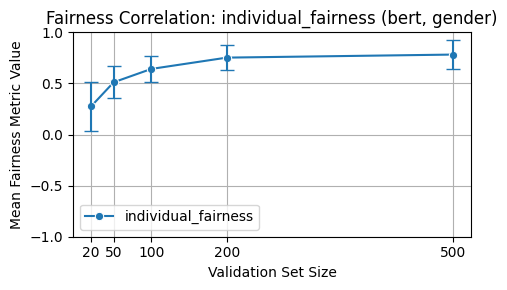

In [13]:
fairness_correlation = {}

for val_num in val_nums[bias_type]:

    for seed in seeds[val_num]:   
        fairness_correlation_file = os.path.join(data_dir, f"{model}_{bias_type}_{train_type}_val_{val_num}_seed_{seed}_test_{test_num[bias_type]}", "fairness_correlation_results.json")
        with open(fairness_correlation_file, "r") as f:
            results = json.load(f)
        metrics = results.keys()
        for metric in metrics:
            if metric not in fairness_correlation:
                fairness_correlation[metric] = {val_num: [] for val_num in val_nums[bias_type]}
            # add if not infinity or None or nan
            if results[metric] not in [float('inf'), None, float('nan')]:
                fairness_correlation[metric][val_num].append(results[metric][0])

# visualize each metric using a line plot, with x-axis as val_num and y-axis as the mean metric value with error bars as the standard deviation
# use seaborn
for metric in fairness_correlation.keys():
    if metric != "individual_fairness":
        continue
    plt.figure(figsize=(5, 3))
    means = []
    stds = []
    for val_num in val_nums[bias_type]:
    
        values = fairness_correlation[metric][val_num]
        means.append(sum(values) / len(values))
        stds.append((sum((x - means[-1]) ** 2 for x in values) / (len(values) - 1)) ** 0.5)
    
    sns.lineplot(x=val_nums[bias_type], y=means, marker='o', label=metric)

    # sd as a whisker 
    # same color as the line
    plt.errorbar(val_nums[bias_type], means, yerr=stds, fmt='none', capsize=5, color=sns.color_palette()[0])

    # y-axis range -1 to 1
    plt.ylim(-1, 1)
    
    plt.title(f"Fairness Correlation: {metric} ({model}, {bias_type})")
    plt.xlabel("Validation Set Size")
    plt.ylabel("Mean Fairness Metric Value")
    plt.xticks(val_nums[bias_type])
    plt.legend()
    plt.grid()
    
    # show the plot
    plt.tight_layout()
    plt.show()
    plt.close()

In [14]:

val_attribution_correlation = {}
for val_num in val_nums[bias_type]:
    if dataset == "jigsaw" and val_num == 500:
        continue
    for seed in seeds[val_num]: 
        val_attribution_correlation_dir = os.path.join(data_dir, f"{model}_{bias_type}_{train_type}_val_{val_num}_seed_{seed}_test_{test_num[bias_type]}")
        for method in explanation_methods:
            val_attribution_correlation_file = os.path.join(val_attribution_correlation_dir, f"{method}_{bias_type}_val_reliance_correlation_results.json")
            with open(val_attribution_correlation_file, "r") as f:
                results = json.load(f)
            aggregations = results.keys()
            for aggregation in aggregations:
                if aggregation not in val_attribution_correlation:
                    val_attribution_correlation[aggregation] = {}
                metrics = results[aggregation].keys()
                for metric in metrics:
                    if metric not in val_attribution_correlation[aggregation]:
                        val_attribution_correlation[aggregation][metric] = {}
                    reliance_methods = results[aggregation][metric].keys()
                    for reliance_method in reliance_methods:
                        if reliance_method not in val_attribution_correlation[aggregation][metric]:
                            val_attribution_correlation[aggregation][metric][reliance_method] = {val_num: [] for val_num in val_nums[bias_type]}
                        # append the first value of the reliance method
                        val_attribution_correlation[aggregation][metric][reliance_method][val_num].append(results[aggregation][metric][reliance_method][0])

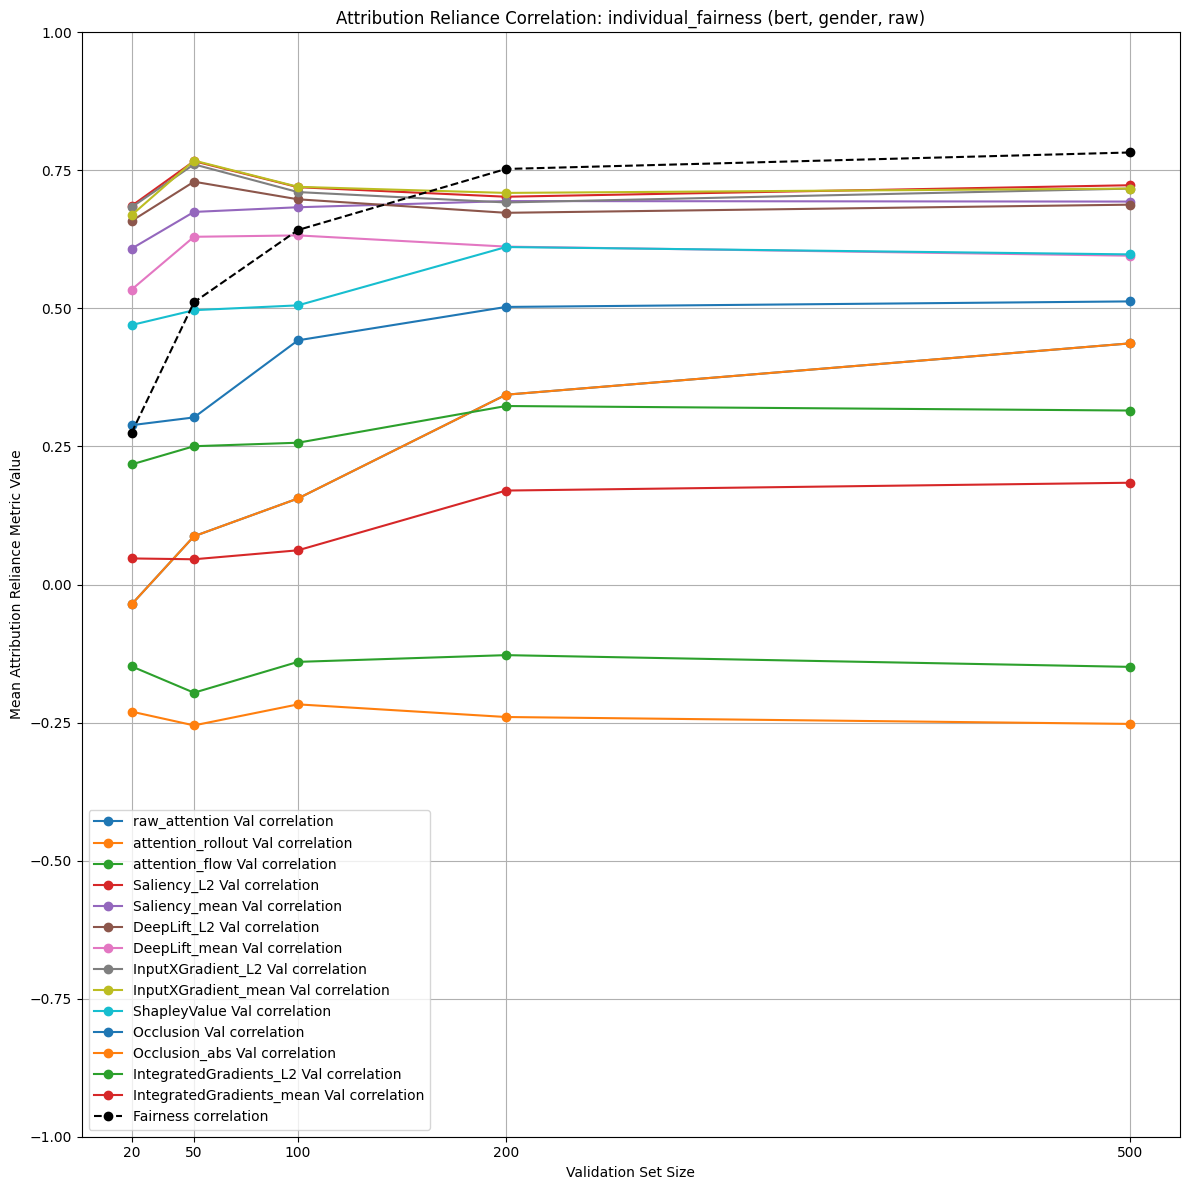

In [15]:
# visualization using seaborn
# visualize the mean and standard deviation of individual fairness score for all aggregation methods
# reliance method is "raw"

metric = "individual_fairness"
reliance_method = "raw"
plt.figure(figsize=(12, 12))
for aggregation in val_attribution_correlation.keys():
    values = val_attribution_correlation[aggregation][metric][reliance_method]
    means = {val_num: sum(values[val_num]) / len(values[val_num]) for val_num in val_nums[bias_type]}
    stds = {val_num: (sum((x - means[val_num]) ** 2 for x in values[val_num]) / (len(values[val_num]) - 1)) ** 0.5 for val_num in val_nums[bias_type]}
    plt.plot(list(val_nums[bias_type]), list(means.values()), marker='o', label=f"{aggregation} Val correlation")
    # plt.errorbar(val_nums[bias_type], list(means.values()), yerr=list(stds.values()), fmt='o-', capsize=5, label=f"{aggregation} Val correlation")

# fairness correlation
fairness_values = fairness_correlation[metric]
fairness_means = {val_num: sum(fairness_values[val_num]) / len(fairness_values[val_num]) for val_num in val_nums[bias_type]}
fairness_stds = {val_num: (sum((x - fairness_means[val_num]) ** 2 for x in fairness_values[val_num]) / (len(fairness_values[val_num]) - 1)) ** 0.5 for val_num in val_nums[bias_type]}
# make sure the color is different from the previous lines
plt.plot(list(val_nums[bias_type]), list(fairness_means.values()), marker='o', linestyle='--', label=f"Fairness correlation", color='black')
# plt.errorbar(val_nums[bias_type], list(fairness_means.values()), yerr=list(fairness_stds.values()), fmt='o--', capsize=5, label=f"Fairness correlation", color='black')

plt.title(f"Attribution Reliance Correlation: {metric} ({model}, {bias_type}, {reliance_method})")
plt.xlabel("Validation Set Size")
plt.ylabel("Mean Attribution Reliance Metric Value")
plt.xticks(val_nums[bias_type])
plt.ylim(-1, 1)
plt.legend()
plt.grid()
# show the plot
plt.tight_layout()
plt.show()
plt.close()